In [1]:
%matplotlib inline

## Exemplo: Classificação de Imagens

Vamos aprender a implementar os seguintes passos:

1. Carregar e normalizar o conjunto de dados CIFAR10
2. Definir a estrutura de uma Rede Neural Convolucional
3. Definir um loop de treinamento
4. Treinar e testar a Rede Neural



## Carregar e normalizar o conjunto de dados CIFAR10

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Exibindo algumas imagens do conjunto de dados
<img src="cifar10.png" >

      ship       frog        cat      horse


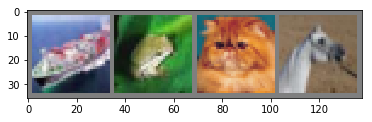

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## Definindo a estrutura da Rede Neural

<img src="cifar10network.png">

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Função de perda e otimizador

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Loop de Treino


In [15]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        #Forward
        inputs, labels = data
        outputs = net(inputs)
        
        #Backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.217
[1,  4000] loss: 1.193
[1,  6000] loss: 1.190
[1,  8000] loss: 1.179
[1, 10000] loss: 1.160
[1, 12000] loss: 1.161
[2,  2000] loss: 1.093
[2,  4000] loss: 1.086
[2,  6000] loss: 1.098
[2,  8000] loss: 1.098
[2, 10000] loss: 1.099
[2, 12000] loss: 1.117
Finished Training


In [11]:
#torch.save(net.state_dict(),'./models/cifar10.dat')
net.load_state_dict(torch.load('./models/cifar10.dat'))

## Testando o modelo

### Algumas imagens:


In [12]:
dataiter = iter(testloader)
# Carrega 4 imagens por default
images, labels = dataiter.next()


In [13]:
outputs = net(images)
print(outputs)

tensor([[-2.4605, -2.1622,  0.7861,  3.9917, -0.8319,  1.8622,  2.1832,
         -1.8778, -0.5419, -0.5589],
        [ 5.5572,  3.9521, -1.3342, -3.6464, -3.2625, -4.2472, -5.0240,
         -2.7819,  5.9302,  1.9248],
        [ 2.9198,  0.7363, -0.6023, -1.7955, -1.2368, -3.0688, -3.3363,
         -1.3895,  3.0572,  1.4606],
        [ 3.4959,  2.7651, -0.5849, -1.6058, -1.9972, -2.6657, -3.6155,
         -1.1330,  1.6031,  1.1483]])


In [14]:
probabilities=torch.exp(outputs)
line_sum=probabilities.sum(1).unsqueeze(0).transpose(0,1)
probabilities=100*(probabilities/line_sum)


In [15]:
def plot_classes(probabilities):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.barh(y=[i for i in range(0,probabilities.size(0))],
            width=[probabilities[i] for i in range(0,probabilities.size(0)) ],
           tick_label= classes)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.show()
    

Ground truth: cat


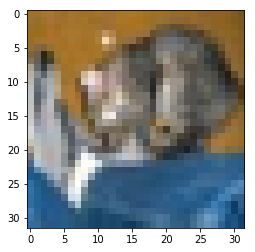

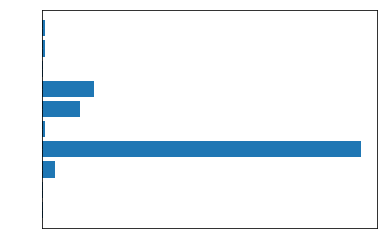

Ground truth: ship


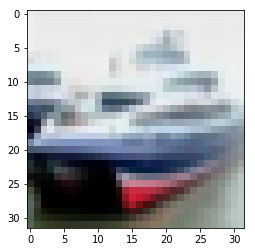

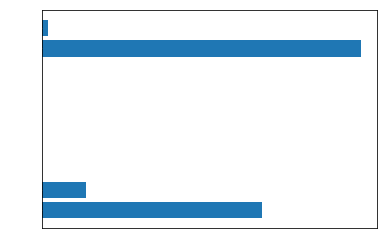

Ground truth: ship


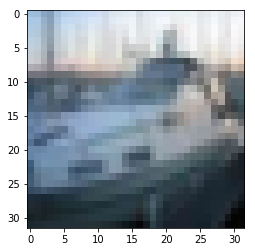

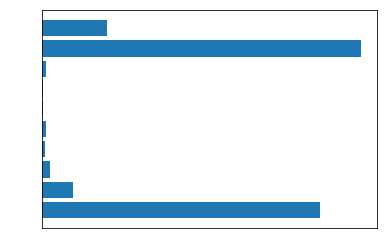

Ground truth: plane


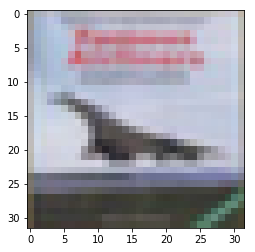

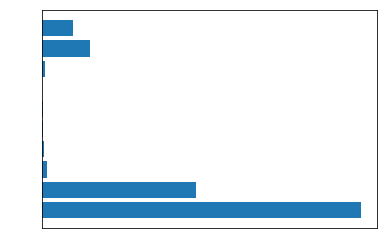

In [21]:
def show_output(n):
    imshow(torchvision.utils.make_grid(images[n]))
    print("Ground truth: "+classes[labels[n]])
    plot_classes(probabilities[n].detach())
 
for i in range(0,4):
    show_output(i)

In [12]:
### Calculando acuracia

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 73 %
Accuracy of  bird : 55 %
Accuracy of   cat : 35 %
Accuracy of  deer : 56 %
Accuracy of   dog : 57 %
Accuracy of  frog : 64 %
Accuracy of horse : 61 %
Accuracy of  ship : 74 %
Accuracy of truck : 71 %


## Treinando na GPU


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Enviando modelos para a GPU:

    inputs, labels = inputs.to(device), labels.to(device)
    net.to(device)

       
